### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

Instalação do kernel = odsc conda install -s generalml_p37_cpu_v1

In [60]:
import ads
import pandas as pd
import numpy as np
from ads.dataset.factory import DatasetFactory
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from ads.common.data import ADSData
from ads.automl.driver import AutoML
from sklearn.ensemble import RandomForestClassifier
from ads.common.model import ADSModel
from ads.evaluations.evaluator import ADSEvaluator
from ads.explanations.explainer import ADSExplainer

In [2]:
np.random.seed(42)

In [3]:
ds_tratado = DatasetFactory.open('dados_final.csv', target='TenYearCHD')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
ds_tratado

HTML(value='\n        <style>\n            .mostly-customized-scrollbar {\n              display: block;\n    …

BinaryClassificationDataset(target: TenYearCHD) 6,954 rows, 17 columns

In [5]:
type(ds_tratado)

ads.dataset.classification_dataset.BinaryClassificationDataset

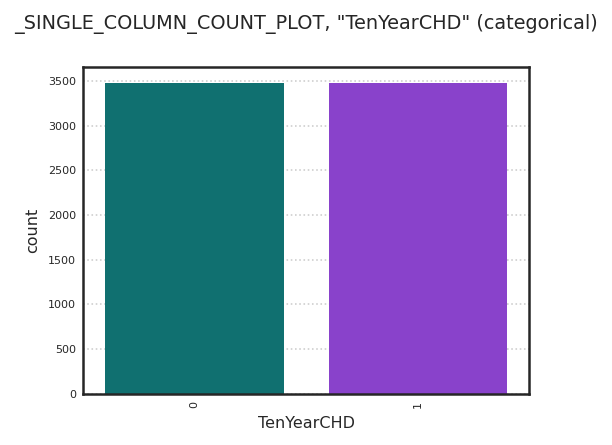

In [6]:
ds_tratado.target.show_in_notebook()

In [7]:
train, test = ds_tratado.train_test_split()

In [8]:
train

Train Data
Shape of X:(6258, 16)
Shape of y:(6258,)

In [9]:
test

Test Data
Shape of X:(696, 16)
Shape of y:(696,)

In [10]:
classificador_simples = DecisionTreeClassifier()

In [11]:
classificador_simples.fit(train.X, train.y)

DecisionTreeClassifier()

In [12]:
classificador_simples.score(test.X, test.y)

0.9066091954022989

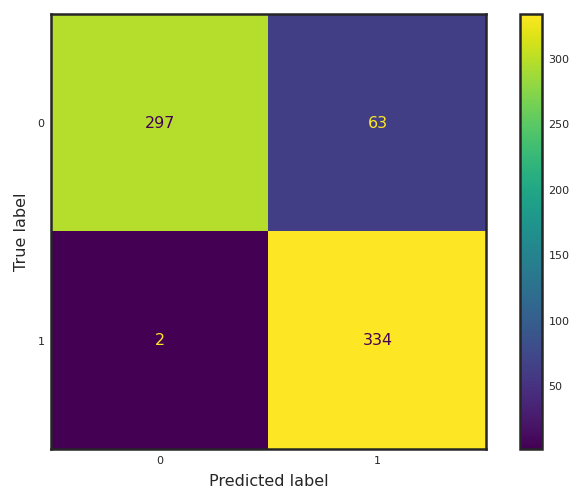

In [13]:
ConfusionMatrixDisplay.from_estimator(classificador_simples, test.X, test.y)

In [14]:
classificador_profundo = DecisionTreeClassifier(max_depth=100)

In [15]:
classificador_profundo.fit(train.X, train.y)

DecisionTreeClassifier(max_depth=100)

In [16]:
classificador_profundo.score(test.X, test.y)

0.9123563218390804

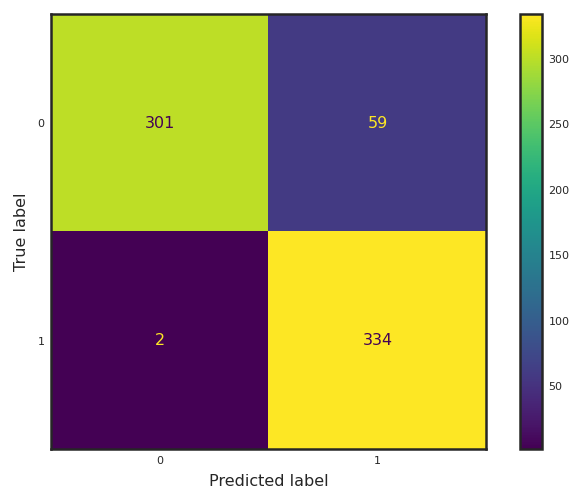

In [17]:
ConfusionMatrixDisplay.from_estimator(classificador_profundo, test.X, test.y)

In [18]:
classificador_simples.feature_importances_

array([0.01703231, 0.17494226, 0.02715909, 0.00167663, 0.05097492,
       0.00292333, 0.00423147, 0.00808341, 0.00101966, 0.13025182,
       0.1391891 , 0.10983777, 0.14044096, 0.07850838, 0.10243698,
       0.01129192])

In [19]:
pd.Series(data=classificador_simples.feature_importances_, index=test.X.columns).sort_values()

diabetes              0.001020
currentSmoker         0.001677
BPMeds                0.002923
prevalentStroke       0.004231
prevalentHyp          0.008083
fumante_categorico    0.011292
male                  0.017032
education             0.027159
cigsPerDay            0.050975
heartRate             0.078508
glucose               0.102437
diaBP                 0.109838
totChol               0.130252
sysBP                 0.139189
BMI                   0.140441
age                   0.174942
dtype: float64

In [20]:
test.X.drop('diabetes', axis=1, inplace=True)

In [21]:
train.X.drop('diabetes', axis=1, inplace=True)

In [22]:
classificador_simples = DecisionTreeClassifier()

In [23]:
classificador_simples.fit(train.X, train.y)

DecisionTreeClassifier()

In [24]:
classificador_simples.score(test.X, test.y)

0.9137931034482759

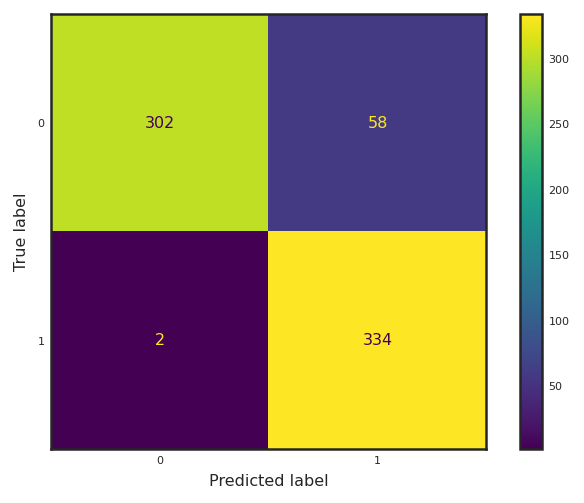

In [25]:
ConfusionMatrixDisplay.from_estimator(classificador_simples, test.X, test.y)

In [28]:
data_ads = ADSData().build(ds_tratado.to_pandas(), 'TenYearCHD')

In [29]:
oracle_automl = AutoML(data_ads)

In [30]:
automl_model1, baseline = oracle_automl.train(score_metric='accuracy', model_list=['RandomForestClassifier', 'DecisionTreeClassifier', 'SVC', 'LogisticRegression'], time_budget=150)

INFO:xengine:All work stopped
INFO:xengine:All work stopped


Training Dataset size,"(6954, 16)"
Validation Dataset size,None
CV,5
Target variable,TenYearCHD
Optimization Metric,accuracy
Initial number of Features,16
Selected number of Features,13
Selected Features,"Index(['male', 'age', 'education', 'cigsPerDay', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'fumante_categorico'], dtype='object')"
Selected Algorithm,RandomForestClassifier
End-to-end Elapsed Time (seconds),62.7386
Selected Hyperparameters,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.07692307692307693, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 252, 'n_jobs': 16, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage
2,RandomForestClassifier_HT,6954,13,0.9350,"{'class_weight': 'balanced_subsample', 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 253}",4.6360,0.0
3,RandomForestClassifier_HT,6954,13,0.9344,"{'class_weight': 'balanced', 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 252}",3.5040,0.0
4,RandomForestClassifier_HT,6954,13,0.9344,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 252}",3.5516,0.0
5,RandomForestClassifier_HT,6954,13,0.9336,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 253}",3.5705,0.0
6,RandomForestClassifier_HT,6954,13,0.9321,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 24}",0.3512,0.0
...,...,...,...,...,...,...,...
117,RandomForestClassifier_HT,6954,13,0.6746,"{'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.13135354258476784, 'n_estimators': 100}",1.8450,0.0
118,RandomForestClassifier_HT,6954,13,0.6680,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.38065381323669234, 'n_estimators': 252}",1.7270,0.0
119,RandomForestClassifier_HT,6954,13,0.6613,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.1313435454608104, 'n_estimators': 5}",0.0702,0.0
120,RandomForestClassifier_HT,6954,13,0.6613,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.13135354258476784, 'n_estimators': 5}",0.0662,0.0


In [31]:
oracle_automl.print_trials()

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage (GB)
RandomForestClassifier_HT,6954,13,0.9359,"{'class_weight': 'balanced_subsample', 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 252}",4.4824,0.0000e+00
RandomForestClassifier_HT,6954,13,0.9350,"{'class_weight': 'balanced_subsample', 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 253}",4.6360,0.0000e+00
RandomForestClassifier_HT,6954,13,0.9344,"{'class_weight': 'balanced', 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 252}",3.5040,0.0000e+00
RandomForestClassifier_HT,6954,13,0.9344,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 252}",3.5516,0.0000e+00
RandomForestClassifier_HT,6954,13,0.9336,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 253}",3.5705,0.0000e+00
RandomForestClassifier_HT,6954,13,0.9321,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 24}",0.3512,0.0000e+00
RandomForestClassifier_HT,6954,13,0.9308,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 100}",1.4201,0.0000e+00
RandomForestClassifier_HT,6954,13,0.9294,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 20}",0.2986,0.0000e+00
RandomForestClassifier_HT,6954,13,0.9287,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 101}",1.3871,0.0000e+00
RandomForestClassifier_AS,5000,16,0.9272,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",6.7087,7.3967e-03


In [33]:
oracle_automl.print_trials(max_rows=20, sort_column='Mean Validation Score')

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage (GB)
RandomForestClassifier_HT,6954,13,0.9359,"{'class_weight': 'balanced_subsample', 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 252}",4.4824,0.0000
RandomForestClassifier_HT,6954,13,0.9350,"{'class_weight': 'balanced_subsample', 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 253}",4.6360,0.0000
RandomForestClassifier_HT,6954,13,0.9344,"{'class_weight': 'balanced', 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 252}",3.5040,0.0000
RandomForestClassifier_HT,6954,13,0.9344,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 252}",3.5516,0.0000
RandomForestClassifier_HT,6954,13,0.9336,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 253}",3.5705,0.0000
RandomForestClassifier_HT,6954,13,0.9321,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 24}",0.3512,0.0000
RandomForestClassifier_HT,6954,13,0.9308,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 100}",1.4201,0.0000
RandomForestClassifier_HT,6954,13,0.9294,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 20}",0.2986,0.0000
RandomForestClassifier_HT,6954,13,0.9287,"{'class_weight': None, 'max_features': 0.07692307692307693, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'n_estimators': 101}",1.3871,0.0000
RandomForestClassifier_AS,5000,16,0.9272,"{'n_estimators': 100, 'class_weight': 'balanced', 'max_features': 0.777777778, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125}",6.7087,0.0074


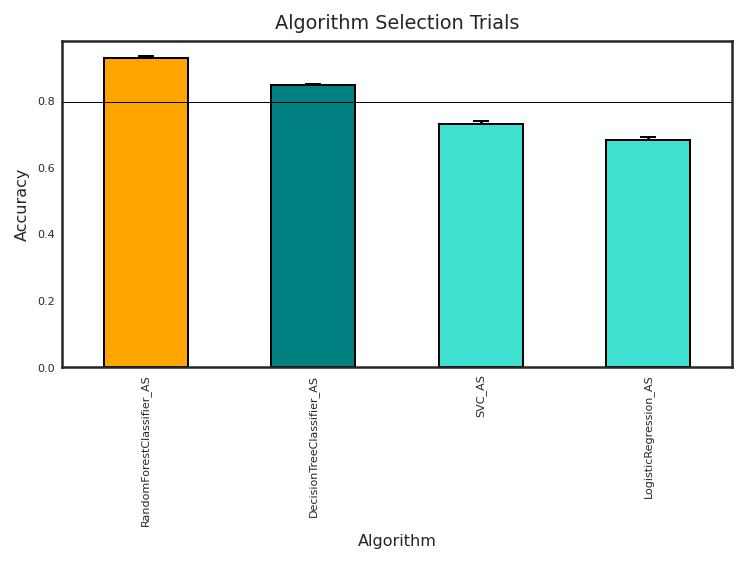

In [34]:
oracle_automl.visualize_algorithm_selection_trials()

In [35]:
automl_model1.show_in_notebook()

Model Name,AutoML Classifier
Target Variable,TenYearCHD
Selected Algorithm,RandomForestClassifier
Task,classification
Training Dataset Size,"(6954, 16)"
CV,5
Optimization Metric,accuracy
Selected Hyperparameters,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.07692307692307693, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 252, 'n_jobs': 16, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}"
Initial Number of Features,16
Initial Features,"Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'fumante_categorico'], dtype='object')"
Selected Number of Features,13


[['Model Name', 'AutoML Classifier'],
 ['Target Variable', 'TenYearCHD'],
 ['Selected Algorithm', 'RandomForestClassifier'],
 ['Task', 'classification'],
 ['Training Dataset Size', (6954, 16)],
 ['CV', 5],
 ['Optimization Metric', 'accuracy'],
 ['Selected Hyperparameters',
  {'bootstrap': True,
   'ccp_alpha': 0.0,
   'class_weight': 'balanced_subsample',
   'criterion': 'gini',
   'max_depth': None,
   'max_features': 0.07692307692307693,
   'max_leaf_nodes': None,
   'max_samples': None,
   'min_impurity_decrease': 0.0,
   'min_samples_leaf': 0.0001438021282714984,
   'min_samples_split': 0.0002876042565429968,
   'min_weight_fraction_leaf': 0.0,
   'n_estimators': 252,
   'n_jobs': 16,
   'oob_score': False,
   'random_state': 7,
   'verbose': 0,
   'warm_start': False}],
 ['Initial Number of Features', 16],
 ['Initial Features',
  Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
         'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
 

  ax.plot(n_features, scores, "k:", marker="s", color="teal", markersize=3)



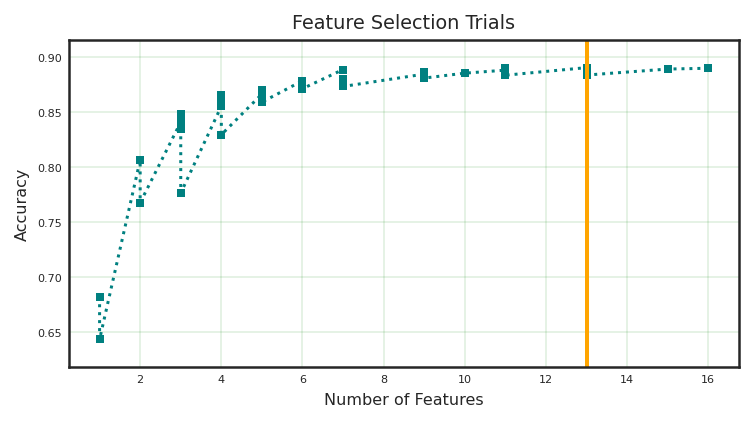

In [36]:
oracle_automl.visualize_feature_selection_trials()

In [37]:
automl_model1.feature_names()

Index(['male', 'age', 'education', 'cigsPerDay', 'prevalentHyp', 'diabetes',
       'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose',
       'fumante_categorico'],
      dtype='object')

In [40]:
train,test = ds_tratado[['male', 'age', 'education', 'cigsPerDay', 'prevalentHyp', 'diabetes',
       'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose',
       'fumante_categorico', 'TenYearCHD']].train_test_split()

In [42]:
automl_model1.summary()

Framework: sklearn.ensemble._forest
Estimator class: RandomForestClassifier
Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.07692307692307693, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 252, 'n_jobs': 16, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}



In [43]:
param_modelo = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.07692307692307693, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.0001438021282714984, 'min_samples_split': 0.0002876042565429968, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 252, 'n_jobs': 16, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}
param_modelo

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.07692307692307693,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.0001438021282714984,
 'min_samples_split': 0.0002876042565429968,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 252,
 'n_jobs': 16,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [44]:
best_model = RandomForestClassifier(**param_modelo)

In [45]:
classificador = DecisionTreeClassifier(max_depth=100)

In [47]:
best_model.fit(train.X, train.y)
classificador.fit(train.X, train.y)

DecisionTreeClassifier(max_depth=100)

In [49]:
ads_best_model = ADSModel.from_estimator(best_model, name='Modelo AutoML')
ads_classificador = ADSModel.from_estimator(classificador, name='Modelo Manual')

In [52]:
evaluator = ADSEvaluator(test_data=test,models=[ads_best_model,ads_classificador],training_data=train)

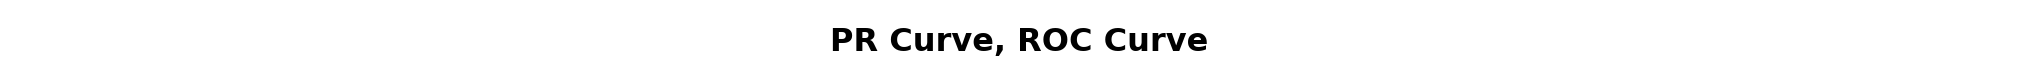

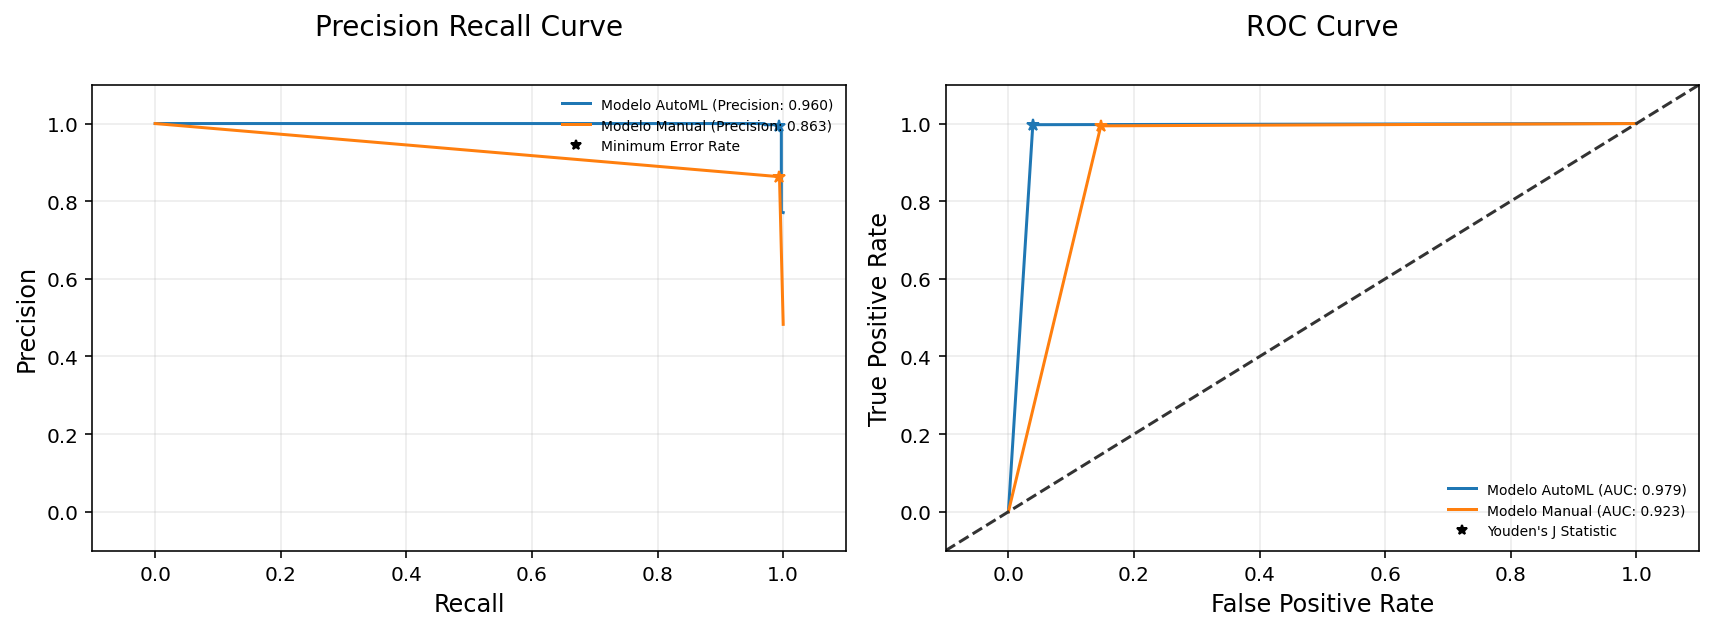

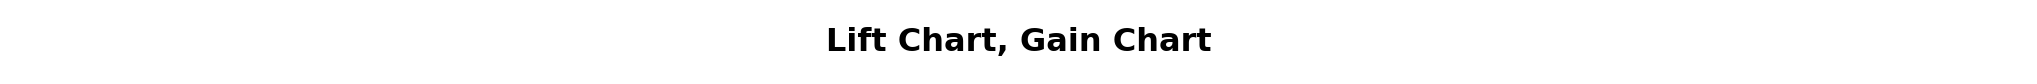

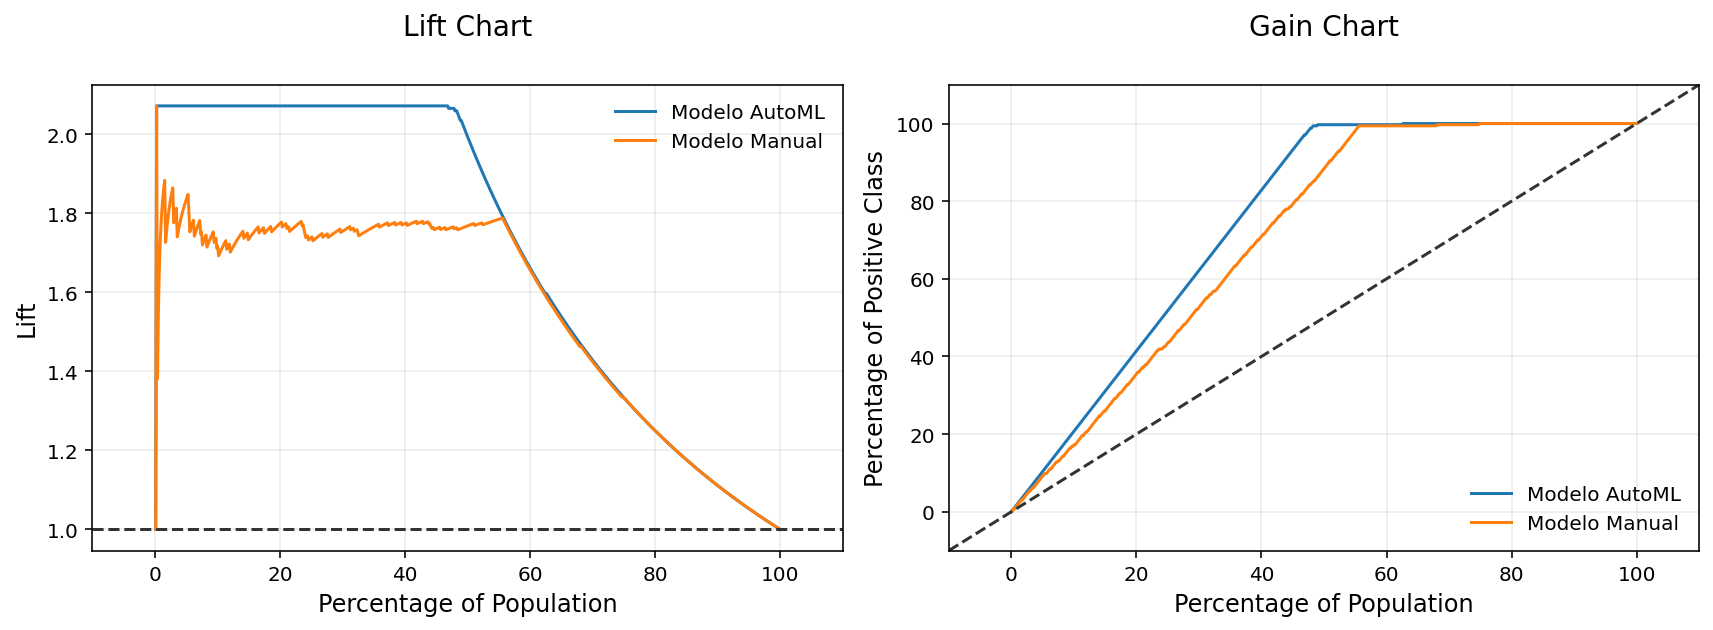

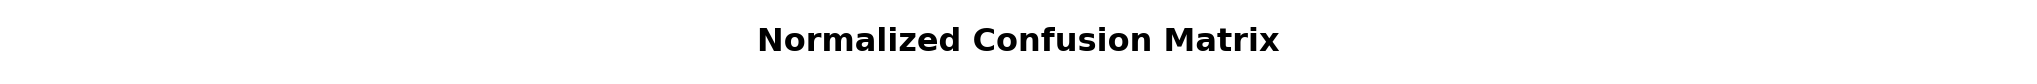

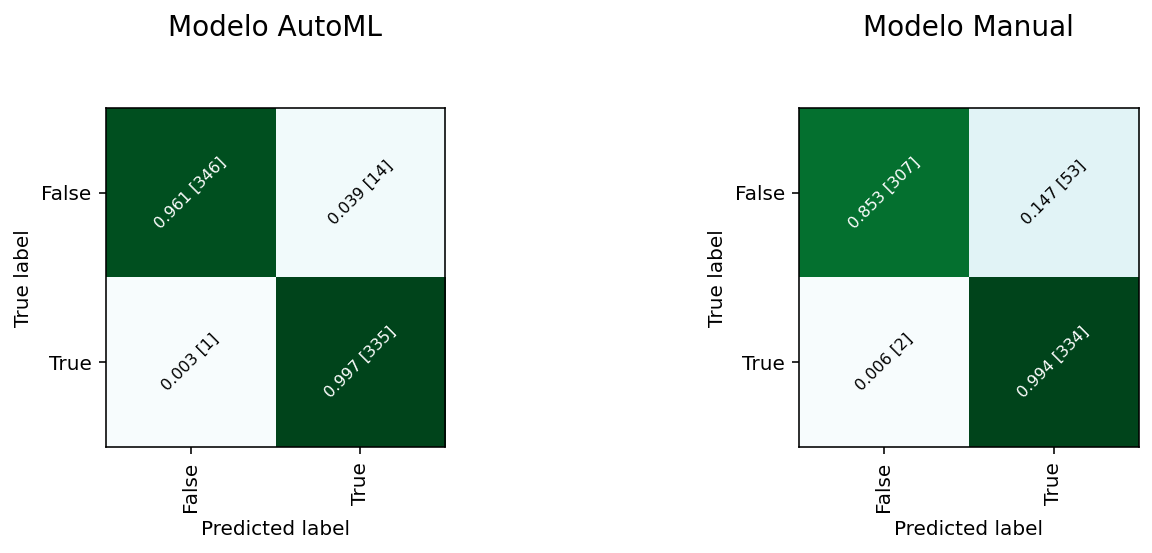

In [53]:
evaluator.show_in_notebook()

In [54]:
evaluator.metrics

  .set_precision(precision)



HTML(value='<style type="text/css">\n#T_f34d1_row0_col0, #T_f34d1_row1_col1, #T_f34d1_row2_col0, #T_f34d1_row3…

HTML(value='<style type="text/css">\n#T_ee96a_row0_col0, #T_ee96a_row0_col1, #T_ee96a_row1_col0, #T_ee96a_row1…

In [55]:
classificador = DecisionTreeClassifier(max_depth=5).fit(train.X, train.y)

In [57]:
ads_classificador = ADSModel.from_estimator(classificador, name='Modelo Manual')

In [58]:
evaluator = ADSEvaluator(test, models=[ads_best_model, ads_classificador], training_data=train)

In [59]:
evaluator.metrics

  .set_precision(precision)



HTML(value='<style type="text/css">\n#T_e48df_row0_col0, #T_e48df_row1_col1, #T_e48df_row2_col0, #T_e48df_row3…

HTML(value='<style type="text/css">\n#T_5e8df_row0_col0, #T_5e8df_row1_col1, #T_5e8df_row2_col0, #T_5e8df_row3…

In [61]:
explainer = ADSExplainer(test, ads_best_model, train)

In [62]:
global_explainer = explainer.global_explanation()

In [64]:
importance = global_explainer.compute_feature_importance()

MLXProgBar:   0%|          | 0/20 [00:00<?, ?it/s]

MLXProgBar:   0%|          | 0/3 [00:00<?, ?it/s]

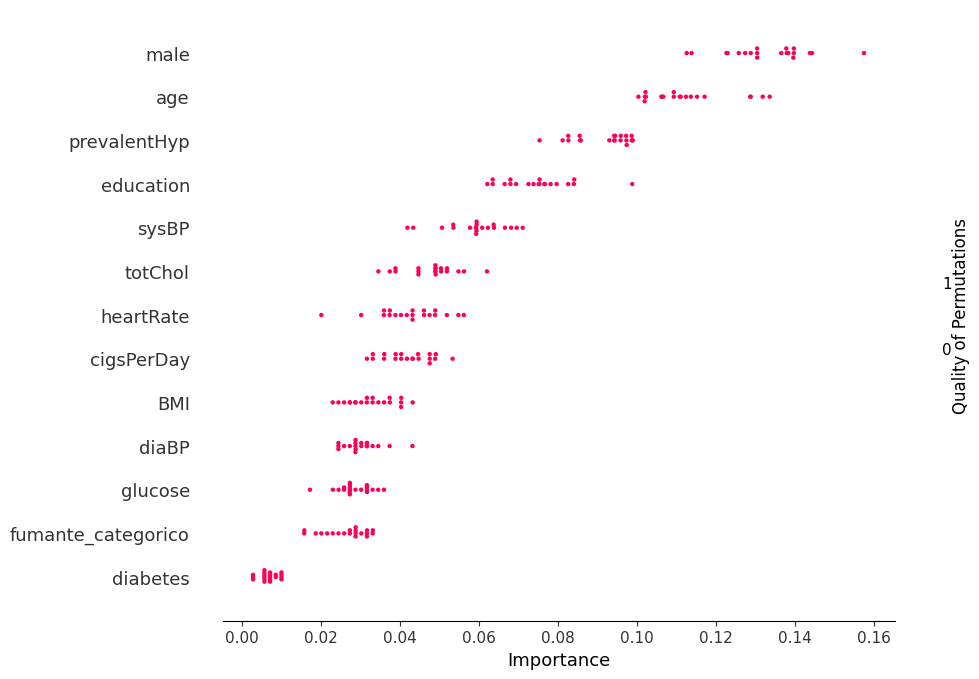

In [66]:
importance.show_in_notebook('detailed')

In [67]:
pdp_idade = global_explainer.compute_partial_dependence('age')

MLXProgBar:   0%|          | 0/30 [00:00<?, ?it/s]

In [68]:
pdp_pressao = global_explainer.compute_partial_dependence('heartRate')

MLXProgBar:   0%|          | 0/24 [00:00<?, ?it/s]

In [73]:
pdp_pressao.show_in_notebook()

In [74]:
local_explainer = explainer.local_explanation()

In [75]:
test.X.iloc[[13]]

,male,age,education,cigsPerDay,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,fumante_categorico
3332,0,62,1.0,0,1,0,312.0,156.0,105.0,22.35,77.0,82.0,0


In [78]:
test.y.iloc[[13]]

3332    0
Name: TenYearCHD, dtype: int64

In [79]:
explanation = local_explainer.explain(test.X.iloc[[13]],test.y.iloc[[13]])

MLXProgBar:   0%|          | 0/1 [00:00<?, ?it/s]

In [81]:
explanation.show_in_notebook()

Feature,Value
age,62.0
diaBP,105.0
sysBP,156.0
male,0.0
cigsPerDay,0.0
prevalentHyp,1.0
fumante_categorico,0.0
education,1.0
diabetes,0.0
totChol,312.0


In [82]:
best_model = RandomForestClassifier(**param_modelo)

In [84]:
automl_model1.feature_names()

Index(['male', 'age', 'education', 'cigsPerDay', 'prevalentHyp', 'diabetes',
       'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose',
       'fumante_categorico'],
      dtype='object')

In [85]:
best_model.fit(ds_tratado[['male', 'age', 'education', 'cigsPerDay', 'prevalentHyp', 'diabetes',
       'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose',
       'fumante_categorico']], ds_tratado['TenYearCHD'])

RandomForestClassifier(class_weight='balanced_subsample',
                       max_features=0.07692307692307693,
                       min_samples_leaf=0.0001438021282714984,
                       min_samples_split=0.0002876042565429968,
                       n_estimators=252, n_jobs=16, random_state=7)

In [86]:
ads_best_model = ADSModel.from_estimator(best_model, name='Modelo AutoML')

In [97]:
path_artifact = 'modelo/'

In [100]:
artifact_model = ads_best_model.prepare(path_artifact, data_sample=test, data_science_env=True, force_overwrite=True)

loop1:   0%|          | 0/5 [00:00<?, ?it/s]

In [101]:
artifact_model.save(display_name='Modelo de Classificação DAC')

ERROR:ads:ADS Exception
Traceback (most recent call last):
  File "/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-101-28bfcdacee82>", line 1, in <module>
    artifact_model.save(display_name='Modelo de Classificação DAC')
  File "/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7/site-packages/ads/common/model_artifact.py", line 779, in save
    ns, training_script_path, ignore_pending_changes
  File "/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7/site-packages/ads/common/model_artifact.py", line 915, in _training_code_info
    self._assert_path_not_dirty(self.artifact_dir, repo, ignore_pending_changes)
  File "/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7/site-packages/ads/common/model_artifact.py", line 931, in _assert_path_not_dirty
    raise ChangesNotCommitted(path_abs)
ads.common.model_art

ChangesNotCommitted: 
            File(s) at /home/datascience/machine-learning-analise-dados-oracle-cloud/modelo are either dirty or untracked.
            Commit changes and then save the model, or set `ignore_pending_changes=True`.
        